# Handling dates and times

Dates and times are messy; a given point in time can be represented in many different ways.
Calculating the interval between two dates and times requires taking into account
leap years, and if one of the dates is far in the past, it requires knowing which [calendar](https://en.wikipedia.org/wiki/Gregorian_calendar)
was used to to specify the date.  On shorter time scales we can be tripped up by time zones and daylight savings time.  And on very short time scales, if we need high accuracy, we need to take into account [leap seconds](https://www.nist.gov/pml/time-and-frequency-division/leap-seconds-faqs).

In our scientific work we should be standardizing on [UTC](https://www.timeanddate.com/time/aboututc.html), so in the following we will mostly ignore time zones.

That still leaves us needing to deal with different data formats, string representations, and library routines.  We will lightly review some of these here. 

[ISO 8601](https://en.wikipedia.org/wiki/ISO_8601) is a standard for writing dates and times.

Netcdf files often use the [CF convention](http://cfconventions.org/Data/cf-conventions/cf-conventions-1.7/cf-conventions.html#time-coordinate) for metadata needed to interpret a time variable in the file.

The python standard library includes the [time](https://docs.python.org/3/library/time.html) module with functions from the C standard library, and the [datetime](https://docs.python.org/3/library/datetime.html#module-datetime) module with date, time, datetime, and timedelta classes.

A few years ago, numpy added 2 new [dtypes](https://numpy.org/doc/stable/reference/arrays.dtypes.html) for working with dates and times: 
[datetime64 and timedelta64](https://numpy.org/doc/stable/reference/arrays.datetime.html). These are used internally by [pandas](https://pandas.pydata.org/docs/user_guide/timeseries.html) and [xarray](http://xarray.pydata.org/en/stable/time-series.html), but with nanosecond precision, so they cannot be used for years before 1678.

For plotting with dates and times on one or both axes, matplotlib internally uses floating point days (sometimes called a "datenum", following Matlab) since an origin (known as an "epoch"), but recognizes both standard library datetime objects (which may be aggregated in arrays with the "object" dtype) and datetime64 arrays.  Related functions and classes are in matplotlib's [dates](https://matplotlib.org/api/dates_api.html) module.

We will also look at some relevant utility functions from [pycurrents](https://currents.soest.hawaii.edu/hgstage/pycurrents/).

Our emphasis will be on time as floating point days or other units since an epoch, and on datetime64; they are more efficient and mostly easier to use than the python standard datetime library classes.

In [1]:
%matplotlib notebook

import datetime
import time

import numpy as np

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from pycurrents.num import rangeslice 
from pycurrents.data.timetools import to_day, to_date, day_to_dt64

plt.rcParams['figure.dpi'] = 80

## Basics, and conversions

For initial purposes of illustration, let's use a short sequence of times at 6-hour intervals starting at the beginning of 2020.  First, suppose it is time in days read from the 'time' variable in a netcdf file.  To simulate it:

In [2]:
t_days_2020 = np.arange(0, 2.01, 0.25)
print(t_days_2020)

[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]


### Float to datetime.datetime

To convert this to a sequence of datetime.datetime objects we need to convert to timedelta objects and add the epoch.  Notice that because the datetime classes are not vectorized, we need to use a loop (here encoded in the list comprehension) and then convert the list to an object array.

In [7]:
epoch_dt_2020 = datetime.datetime(2020, 1, 1)
dt_2020 = np.array([epoch_dt_2020 + datetime.timedelta(days=d) 
                    for d in t_days_2020], dtype=object)
print(dt_2020)
print(datetime.timedelta(days=10.2))
print(np.array([epoch_dt_2020 + datetime.timedelta(days=d) for d in np.arange(0,1,.1)]))

[datetime.datetime(2020, 1, 1, 0, 0) datetime.datetime(2020, 1, 1, 6, 0)
 datetime.datetime(2020, 1, 1, 12, 0) datetime.datetime(2020, 1, 1, 18, 0)
 datetime.datetime(2020, 1, 2, 0, 0) datetime.datetime(2020, 1, 2, 6, 0)
 datetime.datetime(2020, 1, 2, 12, 0) datetime.datetime(2020, 1, 2, 18, 0)
 datetime.datetime(2020, 1, 3, 0, 0)]
10 days, 4:48:00
[datetime.datetime(2020, 1, 1, 0, 0) datetime.datetime(2020, 1, 1, 2, 24)
 datetime.datetime(2020, 1, 1, 4, 48) datetime.datetime(2020, 1, 1, 7, 12)
 datetime.datetime(2020, 1, 1, 9, 36) datetime.datetime(2020, 1, 1, 12, 0)
 datetime.datetime(2020, 1, 1, 14, 24)
 datetime.datetime(2020, 1, 1, 16, 48)
 datetime.datetime(2020, 1, 1, 19, 12)
 datetime.datetime(2020, 1, 1, 21, 36)]


### Float to datetime64

We do something similar for datetime64, but it's all vectorized.  Notice the syntax for making the scalar epoch, including using an ISO-8601 string representation of the date as the argument.

In [13]:
epoch_dt64_2020 = np.datetime64("2020-01-01")
dt64_2020 = epoch_dt64_2020 + np.round(24 * t_days_2020).astype('timedelta64[h]')
print(dt64_2020)
print(dt64_2020.dtype,'\n')
print(np.array(5).astype('timedelta64[h]'))
print(np.array(5).astype('timedelta64[m]'))


['2020-01-01T00' '2020-01-01T06' '2020-01-01T12' '2020-01-01T18'
 '2020-01-02T00' '2020-01-02T06' '2020-01-02T12' '2020-01-02T18'
 '2020-01-03T00']
datetime64[h] 

5 hours
5 minutes


The second line above needs some explanation. The critical points are
- datetime64 and timedelta64 are 64-bit integers, and
- they have units attached to them.

We had to multiply the time in days by 24 to get time in hours.  Since we
happen to know that the times fall on the hour, we chose hours as the largest
unit giving us enough precision.  We could have used any smaller unit.

It is safest to do arithmetic (addition and subtraction) exclusively with
datetime64 and timedelta64.  They don't have to have the same units; if
they differ, the result will have the smallest of the units.  Numpy will
take care of doing the necessary conversions to that smallest common unit 
before adding or subtracting.

It is also *possible* to add plain integers to a 
datetime64, in which case it will be interpreted as timedelta64 with the
same units as the datetime64 to which it is being added.  Notice that in
the example below we do this by including a second argument with the units
when we make the epoch.

In [19]:
epoch_dt64_2020_h = np.datetime64("2020-01-01", 'h')
print(np.datetime64("2020-01-01"),'\n')
print(np.datetime64("2020-01-01",'h'),'\n')
print(np.datetime64("2020-01-01",'m'),'\n')
# The following works, but is not recommended.
dt64_2020_h = epoch_dt64_2020_h + np.round(24 * t_days_2020).astype(int)
print(dt64_2020_h)
print(dt64_2020_h.dtype)

2020-01-01 

2020-01-01T00 

2020-01-01T00:00 

['2020-01-01T00' '2020-01-01T06' '2020-01-01T12' '2020-01-01T18'
 '2020-01-02T00' '2020-01-02T06' '2020-01-02T12' '2020-01-02T18'
 '2020-01-03T00']
datetime64[h]


I prefer the first of these methods, in which the use of datetime64 and
timedelta64 is consistent and explicit.

### More datetime64

Note that datetime64 arrays *display* as string representations,
and can be *created* from strings, but they are actually *stored
and manipulated internally* as 64-bit integers.  For the epoch we
made a scalar datetime64; we can also make an array from a 
list of string representations.  Example:

In [20]:
times = np.array(["2019-01-01", "2019-07-01", "2020-01-01"], dtype='datetime64[D]')
print(times)

['2019-01-01' '2019-07-01' '2020-01-01']


We can use numpy array methods:

In [27]:
dt = np.diff(times)
print(dt)
print(dt.dtype)

print(np.diff(np.array(["2019-01-01", "2019-07-01", "2020-01-01"], dtype='datetime64[h]')))

[181 184]
timedelta64[D]
[4344 4416]


And we can use `np.arange` to make a uniformly-spaced array:

In [35]:
t0 = np.datetime64("2020-03-01")
t1 = np.datetime64("2020-03-03")
dt = np.timedelta64(6, 'h')
six_hourly = np.arange(t0, t1, dt)
print(six_hourly)
print(six_hourly.dtype)
# test
print(np.arange(np.datetime64("2020-01-01"),np.datetime64("2020-01-10"),np.timedelta64(1,'D')))

['2020-03-01T00' '2020-03-01T06' '2020-03-01T12' '2020-03-01T18'
 '2020-03-02T00' '2020-03-02T06' '2020-03-02T12' '2020-03-02T18']
datetime64[h]
['2020-01-01' '2020-01-02' '2020-01-03' '2020-01-04' '2020-01-05'
 '2020-01-06' '2020-01-07' '2020-01-08' '2020-01-09']


The pycurrents `rangeslice` function works with datetime64:

In [36]:
sl = rangeslice(six_hourly, np.datetime64("2020-03-01T17"), 
                np.datetime64("2020-03-02T15"))
print(six_hourly[sl])

['2020-03-01T18' '2020-03-02T00' '2020-03-02T06' '2020-03-02T12']


### Datetime64 to float

Although calculations can be done with datetime64, there are some 
limitations of working with integers, so usually one needs time
as a floating point array in some units since an epoch.  Here is 
an example, going from the `dt64_2020` array we calculated earlier
to an array matching our original `t_days_2020`:

In [37]:
t_days_2020_r = (dt64_2020 - epoch_dt64_2020).astype(np.float64) / 24
print(t_days_2020_r)
print(t_days_2020_r.dtype)
print((t_days_2020_r == t_days_2020).all())

[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
float64
True


The subtraction in the line above gave us a timedelta64[h] array, 
and it was critical that we converted that to floating point 
before dividing by 24 to get back to days.

## Plotting with a date-time axis

Matplotlib has tick locating and labeling code that is customized for
dates and times.  It is invoked automatically if a coordinate array
is supplied as either an object array of datetime.datetime instances 
or an ndarray with a datetime64 dtype.  Let's start with a simple example.
We will make a floating point time array in days since the beginning of
the year, with arbitrary but close spacing, and then generate a sine wave
with one cycle per day so we have something to plot. For plotting, we
will make a datetime64 array.  Precision at the 1-s level will be adequate.

In [38]:
t = np.linspace(20, 23, 100)
y = np.sin(2 * np.pi * t)
t_dt64 = np.datetime64("2020-01-01") + np.round(t * 86400).astype("timedelta64[s]")
print(t_dt64[:3])

['2020-01-21T00:00:00' '2020-01-21T00:43:38' '2020-01-21T01:27:16']


Date-time tick labels tend to be long and potentially overlapping, so
we use `fig.autofmt_xdate()` to add extra space to the bottom and then
tilt the labels. 

<IPython.core.display.Javascript object>


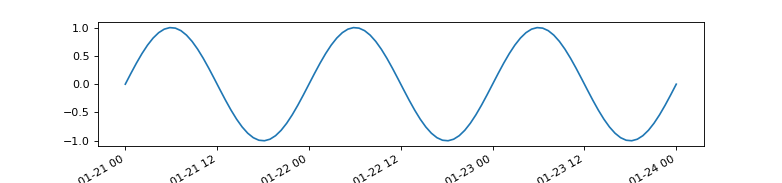

In [45]:
fig, ax = plt.subplots()
ax.plot(t_dt64, y)
fig.autofmt_xdate()

Currently, `autofmt_xdate` doesn't work with the new "constrained layout"
option, but we can make a function to get the same effect.

<IPython.core.display.Javascript object>


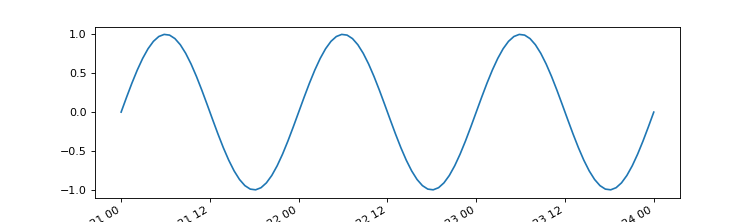

In [44]:
def tilt_xlabels(ax, rotation=30):
    for label in ax.get_xticklabels(which='major'):
        label.set_ha('right')
        label.set_rotation(rotation)
        
fig, ax = plt.subplots(constrained_layout=False)
ax.plot(t_dt64, y)
tilt_xlabels(ax)